<a href="https://colab.research.google.com/github/pradyumna4998/Intro-to-ML/blob/main/HW7_Q1_IntroToML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Introduction to Machine Learning
                              Homework 7

Name: V.pradyumna

Student ID : 801345963


In [17]:
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.21 s (started: 2024-12-04 17:01:54 +00:00)


In [18]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)
np.random.seed(123)


time: 3.06 ms (started: 2024-12-04 17:01:56 +00:00)


In [19]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

time: 3.06 ms (started: 2024-12-04 17:01:56 +00:00)


In [20]:

training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Calculating mean and standard(std)
images = torch.stack([img_t for img_t, _ in training_dataset], dim=3)
mean = images.view(3, -1).mean(dim=1)
std = images.view(3, -1).std(dim=1)

Files already downloaded and verified
time: 24.2 s (started: 2024-12-04 17:01:56 +00:00)


In [21]:
mean

tensor([0.4914, 0.4822, 0.4465])

time: 3.47 ms (started: 2024-12-04 17:02:20 +00:00)


In [22]:
std

tensor([0.2470, 0.2435, 0.2616])

time: 3.62 ms (started: 2024-12-04 17:02:20 +00:00)


In [23]:
cifar10 = datasets.CIFAR10(
    './data', train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))


time: 556 ms (started: 2024-12-04 17:02:20 +00:00)


In [24]:
cifar10_testing = datasets.CIFAR10(
     './data', train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))


time: 387 ms (started: 2024-12-04 17:02:21 +00:00)


In [25]:

image1, label = cifar10[0]
print(image1.shape)

torch.Size([3, 32, 32])
time: 2 ms (started: 2024-12-04 17:02:21 +00:00)


In [26]:
training_loader = DataLoader(cifar10, batch_size=32, shuffle=True, num_workers=2)
testing_loader = DataLoader(cifar10_testing, batch_size=32, shuffle=False, num_workers=2)

time: 609 µs (started: 2024-12-04 17:02:21 +00:00)


In [27]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

time: 3.22 ms (started: 2024-12-04 17:02:21 +00:00)


In [28]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # <1>
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

time: 977 µs (started: 2024-12-04 17:02:21 +00:00)


In [29]:

model = Net().to(device)

time: 2.28 ms (started: 2024-12-04 17:02:21 +00:00)


In [30]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18354, [432, 16, 1152, 8, 16384, 32, 320, 10])

time: 5 ms (started: 2024-12-04 17:02:21 +00:00)


In [31]:
import datetime

def training_loop(epochs, optimizer, model, loss_function, training_loader):
    for epoch in range(1, epochs + 1):
        training_loss = 0.0
        for images, labels in training_loader:
            images = images.to(device=device)  # <1>
            labels = labels.to(device=device)
            outputs = model(images)
            loss = loss_function(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            training_loss += loss.item()

        if epoch == 1 or epoch % 2 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, training_loss/ len(training_loader)))

time: 1.41 ms (started: 2024-12-04 17:02:21 +00:00)


In [32]:
training_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=True)

model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_function = nn.CrossEntropyLoss()

training_loop(
    epochs = 200,
    optimizer = optimizer,
    model = model,
    loss_function = loss_function,
    training_loader = training_loader,
)


2024-12-04 17:02:47.482296 Epoch 1, Training loss 2.06806315012905
2024-12-04 17:03:05.900147 Epoch 2, Training loss 1.7975618258461623
2024-12-04 17:03:32.787536 Epoch 4, Training loss 1.5253500965855005
2024-12-04 17:04:00.177508 Epoch 6, Training loss 1.3815415445953378
2024-12-04 17:04:27.038645 Epoch 8, Training loss 1.2716946279453805
2024-12-04 17:04:54.215582 Epoch 10, Training loss 1.193928534493727
2024-12-04 17:05:21.603234 Epoch 12, Training loss 1.1361413646841902
2024-12-04 17:05:48.577601 Epoch 14, Training loss 1.0900413743827655
2024-12-04 17:06:15.598092 Epoch 16, Training loss 1.0553654136560153
2024-12-04 17:06:43.717572 Epoch 18, Training loss 1.0226405362034088
2024-12-04 17:07:10.506114 Epoch 20, Training loss 0.995345059182028
2024-12-04 17:07:37.324647 Epoch 22, Training loss 0.9691588150723206
2024-12-04 17:08:04.255413 Epoch 24, Training loss 0.9483433722535057
2024-12-04 17:08:30.835266 Epoch 26, Training loss 0.9291621108951471
2024-12-04 17:08:57.562518 Ep

In [33]:
import collections
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar10_testing, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    acc_dict = {}
    predictions = []
    exp_labels = []

    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

                predictions.extend(predicted.cpu().numpy())
                exp_labels.extend(labels.cpu().numpy())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        acc_dict[name] = correct / total
    return acc_dict, predictions, exp_labels

time: 1.24 ms (started: 2024-12-04 17:46:55 +00:00)


In [34]:
accuracy, predictions, expected_labels = validate(model, train_loader, val_loader)

Accuracy train: 0.76
Accuracy val: 0.62
time: 14.5 s (started: 2024-12-04 17:46:55 +00:00)


In [35]:
print(classification_report(predictions, expected_labels, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.78      0.72      0.75      6496
  automobile       0.92      0.74      0.82      7458
        bird       0.63      0.68      0.65      5516
         cat       0.55      0.63      0.59      5252
        deer       0.73      0.66      0.69      6624
         dog       0.59      0.76      0.66      4633
        frog       0.78      0.80      0.79      5846
       horse       0.78      0.78      0.78      5987
        ship       0.89      0.74      0.81      7280
       truck       0.70      0.86      0.77      4908

    accuracy                           0.74     60000
   macro avg       0.74      0.74      0.73     60000
weighted avg       0.75      0.74      0.74     60000

time: 78.3 ms (started: 2024-12-04 17:47:09 +00:00)


In [36]:
precision = precision_score(predictions, expected_labels, average='macro')
recall = recall_score(predictions, expected_labels, average='macro')
cnf_matrix = confusion_matrix(predictions, expected_labels)

time: 125 ms (started: 2024-12-04 17:47:09 +00:00)


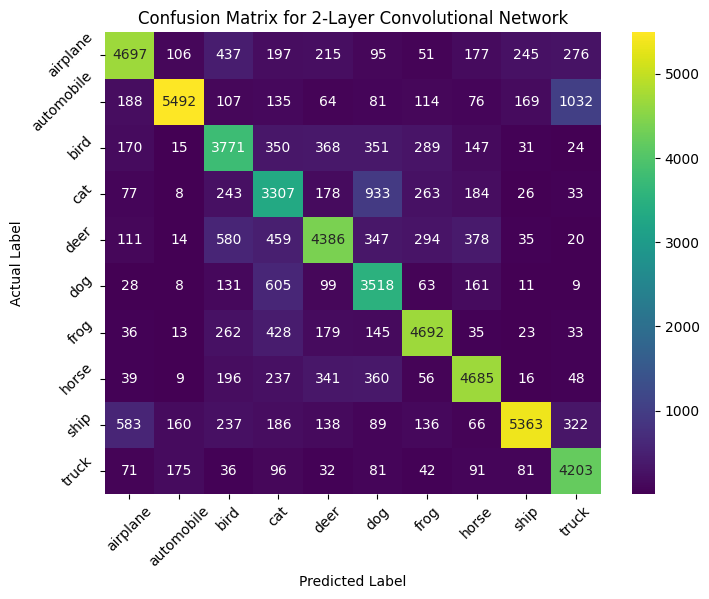

time: 510 ms (started: 2024-12-04 17:47:10 +00:00)


In [37]:
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, cmap="viridis", fmt='g',
            xticklabels = class_names, yticklabels = class_names)
plt.title('Confusion Matrix for 2-Layer Convolutional Network')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()

Problem:1)b)

In [38]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(8, 4, kernel_size=3, padding=1)
        self.act3 = nn.Tanh()
        self.pool3 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(4 * 4 * 4, 32)
        self.act4 = nn.Tanh()
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = self.pool3(self.act3(self.conv3(out)))
        out = out.view(-1, 4 * 4 * 4)
        out = self.act4(self.fc1(out))
        out = self.fc2(out)
        return out

time: 1.62 ms (started: 2024-12-04 17:47:10 +00:00)


In [39]:
model2 = Net2().to(device)

time: 2.74 ms (started: 2024-12-04 17:47:10 +00:00)


In [40]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18354, [432, 16, 1152, 8, 16384, 32, 320, 10])

time: 4.27 ms (started: 2024-12-04 17:47:10 +00:00)


In [41]:
training_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=True)

model2 = Net2().to(device=device)
optimizer2 = optim.SGD(model2.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    epochs = 200,
    optimizer = optimizer2,
    model = model2,
    loss_function = loss_function,
    training_loader = training_loader,
)

2024-12-04 17:47:24.241416 Epoch 1, Training loss 2.1501617623716975
2024-12-04 17:47:37.567253 Epoch 2, Training loss 1.9213429161959596
2024-12-04 17:48:04.224899 Epoch 4, Training loss 1.6694912954669474
2024-12-04 17:48:31.793529 Epoch 6, Training loss 1.5563969735599235
2024-12-04 17:48:59.500587 Epoch 8, Training loss 1.4677112651298114
2024-12-04 17:49:26.526528 Epoch 10, Training loss 1.3981269469956303
2024-12-04 17:49:53.260386 Epoch 12, Training loss 1.341702952561781
2024-12-04 17:50:19.988969 Epoch 14, Training loss 1.3008434125377089
2024-12-04 17:50:46.695819 Epoch 16, Training loss 1.2667528892417088
2024-12-04 17:51:13.298239 Epoch 18, Training loss 1.237647765509003
2024-12-04 17:51:39.958940 Epoch 20, Training loss 1.2138319965975974
2024-12-04 17:52:07.213142 Epoch 22, Training loss 1.1913807973684862
2024-12-04 17:52:33.819104 Epoch 24, Training loss 1.1723109274111745
2024-12-04 17:53:00.295321 Epoch 26, Training loss 1.1574608512089382
2024-12-04 17:53:26.834812 

In [42]:
val_loader = torch.utils.data.DataLoader(cifar10_testing, batch_size=64,
                                         shuffle=False)

time: 606 µs (started: 2024-12-04 18:31:51 +00:00)


In [43]:
accuracy2, predictions2, expected_labels2 = validate(model2, training_loader, val_loader)

Accuracy train: 0.64
Accuracy val: 0.61
time: 14.5 s (started: 2024-12-04 18:31:51 +00:00)


In [44]:

print(classification_report(predictions2, expected_labels2, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.69      0.57      0.63      7232
  automobile       0.89      0.65      0.75      8194
        bird       0.47      0.58      0.52      4907
         cat       0.35      0.51      0.41      4099
        deer       0.46      0.72      0.56      3845
         dog       0.53      0.55      0.54      5831
        frog       0.61      0.82      0.70      4418
       horse       0.74      0.62      0.68      7089
        ship       0.85      0.62      0.72      8297
       truck       0.73      0.72      0.72      6088

    accuracy                           0.63     60000
   macro avg       0.63      0.64      0.62     60000
weighted avg       0.67      0.63      0.64     60000

time: 50.7 ms (started: 2024-12-04 18:32:05 +00:00)


In [45]:
precision2 = precision_score(predictions2, expected_labels2, average='macro')
recall2 = recall_score(predictions2, expected_labels2, average='macro')
cnf_matrix2 = confusion_matrix(predictions2, expected_labels2)


time: 118 ms (started: 2024-12-04 18:32:05 +00:00)


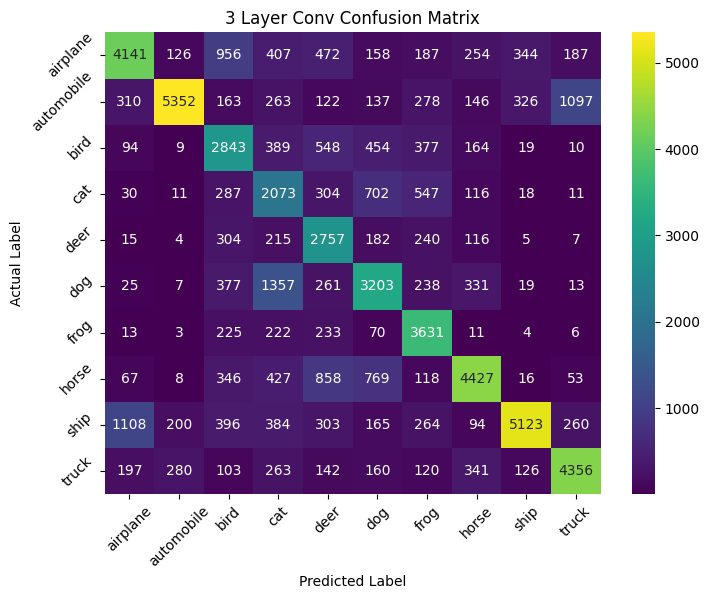

time: 616 ms (started: 2024-12-04 18:32:05 +00:00)


In [46]:
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix2, annot=True, cmap="viridis", fmt='g',
            xticklabels = class_names, yticklabels = class_names)
plt.title('3 Layer Conv Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()